## Swissgrid Data Time Series Analysis

This Jupyter notebook is a slightly modified version of [this](https://ucilnica.fri.uni-lj.si/mod/resource/view.php?id=28089) notebook which shows some of the basic analysis tools for time series in a really great summary.  

### Introduction to Time Series Forecasting
Time series is different from more traditional classification and regression predictive modeling problems. The temporal structure adds an order to the observations. This imposed order means that important assumptions about the consistency of those observations needs to be handled specifically.

The goal of Time Series Forecasting is to make accurate predictions about the future. In this Jupyter Notebook, we will focus on how to make predictions on univariate time series problems using the standard tools in the Python ecosystem. Pandas library in Python provides excellent, built-in support for time series data, while Statsmodels is a Python module that allows users to explore data, estimate statistical models, and perform statistical tests.

For learning Time Series Forecasting with Python, we recommend you an excellent book Introduction to Time Forecasting with Python (2017) by Jason Brownlee. Several examples and techniques in this notebook are presented and explained in more details in that book.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
#from pandas import TimeGrouper
#from pandas.tools.plotting import lag_plot
#from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AutoReg 
from statsmodels.tsa.arima.model import ARIMA
import tqdm

In [6]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

In [7]:

# load dataset
dataframe = pd.read_csv("/examples/time_series_analysis/swissgrid_total_load.csv",
                        index_col='timestamp',
                        dtype={'MW': np.float32},
                        parse_dates=True, 
                        #date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                       )

In [9]:
# display first few lines of a time series
dataframe.head()

,MW
timestamp,
2013-01-01 01:00:00,6133.65
2013-01-01 02:00:00,5995.05
2013-01-01 03:00:00,5790.13
2013-01-01 04:00:00,5448.47
2013-01-01 05:00:00,5077.96


In [12]:
# create a time series
s = pd.Series(dataframe.unstack().values, index=dataframe.index)

<AxesSubplot:xlabel='timestamp'>

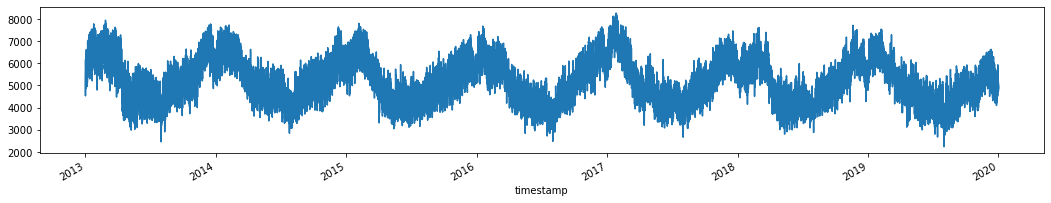

In [15]:
# basic plot
s.plot()

In [17]:
# query a dataset using a date-time index
s[:'2013'].tail(10)

timestamp
2013-12-31 14:00:00   5887.85
2013-12-31 15:00:00   5770.22
2013-12-31 16:00:00   5791.03
2013-12-31 17:00:00   6048.92
2013-12-31 18:00:00   6542.79
2013-12-31 19:00:00   6498.86
2013-12-31 20:00:00   6225.88
2013-12-31 21:00:00   6024.92
2013-12-31 22:00:00   6026.00
2013-12-31 23:00:00   6194.36
dtype: float32

In [18]:
# display first few lines of a time series
s.head()

timestamp
2013-01-01 01:00:00   6133.65
2013-01-01 02:00:00   5995.05
2013-01-01 03:00:00   5790.13
2013-01-01 04:00:00   5448.47
2013-01-01 05:00:00   5077.96
dtype: float32

In [19]:
s.index[:5]

DatetimeIndex(['2013-01-01 01:00:00', '2013-01-01 02:00:00',
               '2013-01-01 03:00:00', '2013-01-01 04:00:00',
               '2013-01-01 05:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [20]:
# display last few lines of a time series
s.tail()

timestamp
2019-12-31 20:00:00   4761.71
2019-12-31 21:00:00   4770.17
2019-12-31 22:00:00   4742.61
2019-12-31 23:00:00   4842.42
2020-01-01 00:00:00   4980.63
dtype: float32

In [21]:
# summarize the dimensions of a time series
s.size

61344

In [22]:
# calculate descriptive statistics
s.describe()

count   61344.00
mean     5166.39
std      1006.20
min      2232.48
25%      4366.41
50%      5083.96
75%      5915.51
max      8255.07
dtype: float64

In [24]:
# query a dataset using a date-time index
s['2014-06':'2016-06']

timestamp
2014-06-01 00:00:00   4165.20
2014-06-01 01:00:00   4514.91
2014-06-01 02:00:00   4437.78
2014-06-01 03:00:00   4371.13
2014-06-01 04:00:00   4283.88
                        ...  
2016-06-30 19:00:00   4361.50
2016-06-30 20:00:00   4123.33
2016-06-30 21:00:00   3972.24
2016-06-30 22:00:00   3956.63
2016-06-30 23:00:00   4020.88
Length: 18264, dtype: float32

### Basic Feature Engineering
Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms. There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.
A time series dataset must be transformed to be modeled as a supervised learning problem. We need to transform something that looks like:

    time 1, value 1
    time 2, value 2
    time 3, value 3
    
into something that looks like:

    input 1, output 1
    input 2, output 2
    input 3, output 3
    
### Date Time Features
The simplest features that we can use are features from the date/time of each observation.

### Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the current time (t). The supervised learning problem with shifted values looks as follows:

    Value(t), Value(t+1)
    Value(t), Value(t+1)
    Value(t), Value(t+1)
    
### Window Features
The addition of lag features is called the sliding window method, in this case with a window width of 1. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width. We can expand the window width and include more lagged features.

[3, 2, 1, 0]

In [153]:
def make_sliding_window(len_past, len_future=1):
    #define length of rolling window
    offsets = [len_past-i-1 for i in range(len_past)]+ [-(i+1) for i in range(len_future)]

    #build rolling window
    sliding_window = pd.concat(
        [s.shift(i) for i in offsets], axis=1)

    #rename columns
    sliding_window.columns = ["t{}".format(-i) for i in offsets]

    return sliding_window



In [158]:
sliding_window = make_sliding_window(4)

In [159]:
sliding_window.head(10)

,t-3,t-2,t-1,t0,t1
timestamp,,,,,
2013-01-01 01:00:00,NaN,NaN,NaN,6133.65,5995.05
2013-01-01 02:00:00,NaN,NaN,6133.65,5995.05,5790.13
2013-01-01 03:00:00,NaN,6133.65,5995.05,5790.13,5448.47
2013-01-01 04:00:00,6133.65,5995.05,5790.13,5448.47,5077.96
2013-01-01 05:00:00,5995.05,5790.13,5448.47,5077.96,4955.34
2013-01-01 06:00:00,5790.13,5448.47,5077.96,4955.34,4805.10
2013-01-01 07:00:00,5448.47,5077.96,4955.34,4805.10,4593.82
2013-01-01 08:00:00,5077.96,4955.34,4805.10,4593.82,4526.17
2013-01-01 09:00:00,4955.34,4805.10,4593.82,4526.17,4600.21


### Rolling Window Statistics
A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous values, also called the rolling mean.

In [57]:
values = pd.DataFrame(s.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df = pd.concat([means, values], axis=1)
df.columns = ['mean(t-1,t)', 't+1']

In [58]:
df.head()

,"mean(t-1,t)",t+1
0,NaN,6133.65
1,NaN,5995.05
2,6064.35,5790.13
3,5892.59,5448.47
4,5619.30,5077.96


In [59]:
values = pd.DataFrame(s.values)
width = 3
shifted = values.shift(width - 1)
window = shifted.rolling(window=width)

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']

In [61]:
df.head()

,min,mean,max,t+1
0,NaN,NaN,NaN,6133.65
1,NaN,NaN,NaN,5995.05
2,NaN,NaN,NaN,5790.13
3,NaN,NaN,NaN,5448.47
4,5790.13,5972.94,6133.65,5077.96


### Expanding Window Statistics
Another type of window that may be useful includes all previous data in the series. This is called an expanding window and can help with keeping track of the bounds of observable data.

In [62]:

values = pd.DataFrame(s.values)
window = values.expanding()

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']

In [65]:
df.head()

,min,mean,max,t+1
61339,2232.48,5166.41,8255.07,4761.71
61340,2232.48,5166.41,8255.07,4770.17
61341,2232.48,5166.40,8255.07,4742.61
61342,2232.48,5166.39,8255.07,4842.42
61343,2232.48,5166.39,8255.07,4980.63


In [66]:
df.tail()

,min,mean,max,t+1
61339,2232.48,5166.41,8255.07,4761.71
61340,2232.48,5166.41,8255.07,4770.17
61341,2232.48,5166.40,8255.07,4742.61
61342,2232.48,5166.39,8255.07,4842.42
61343,2232.48,5166.39,8255.07,4980.63


## Data Visualization
Time series lends itself naturally to visualization. Line plots of observations over time are popular, but there is a suite of other plots that you can use to learn more about your problem. The more you learn about your data, the more likely you are to develop a better forecasting model.

### Line Plot
Perhaps the most popular visualization for time series is the line plot. In this plot, time is shown on the x-axis with observation values along the y-axis.

<AxesSubplot:xlabel='timestamp'>

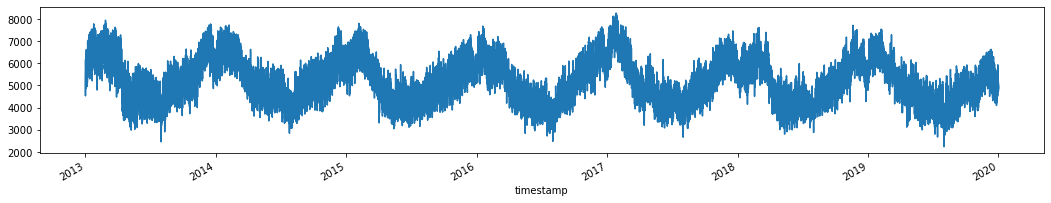

In [67]:
s.plot()

<AxesSubplot:xlabel='timestamp'>

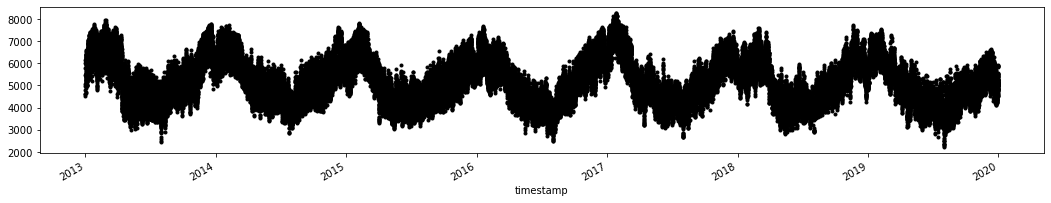

In [68]:
s.plot(style='k.')

### Histogram and Density Plots
Another important visualization is of the distribution of observations themselves. This means a plot of the values without the temporal ordering. Some linear time series forecasting methods assume a well-behaved distribution of observations (i.e. a bell curve or normal distribution). This can be explicitly checked using tools like statistical hypothesis tests. But plots can provide a useful first check of the distribution of observations both on raw observations and after any type of data transform has been performed.

<AxesSubplot:>

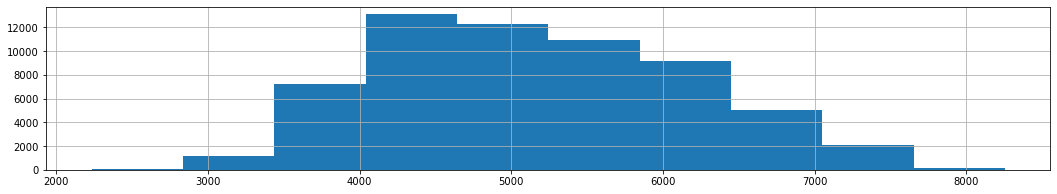

In [69]:
s.hist()


<AxesSubplot:ylabel='Density'>

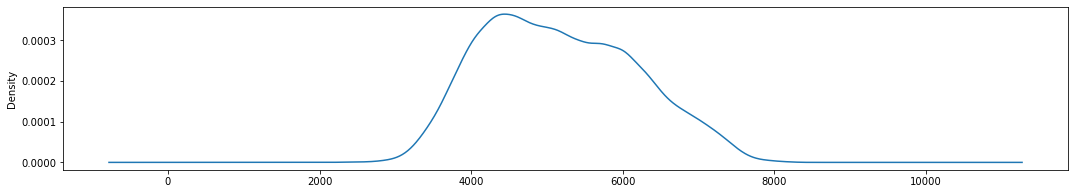

In [70]:
s.plot(kind='kde')


### Box and Whisker Plots
Histograms and density plots provide insight into the distribution of all observations, but we may be interested in the distribution of values by time interval. Another type of plot that is useful to summarize the distribution of observations is the box and whisker plot. This plot draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations. Dots are drawn for outliers outside the whiskers or extents of the data.

In [81]:
years, vals = [], []
for name, gr in s.groupby(pd.Grouper(freq="Y")):
    years.append(name.year)
    vals.append(gr.values)
df = pd.DataFrame(vals, index=years).iloc[:-1]


<AxesSubplot:>

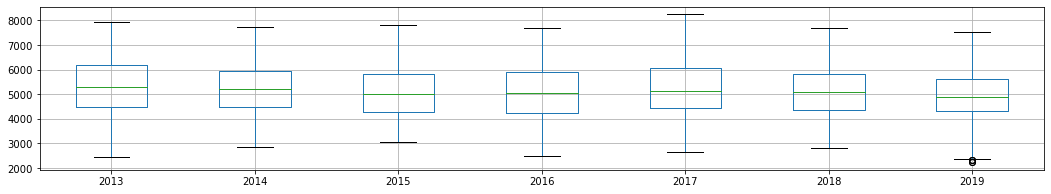

In [82]:
df.T.boxplot()

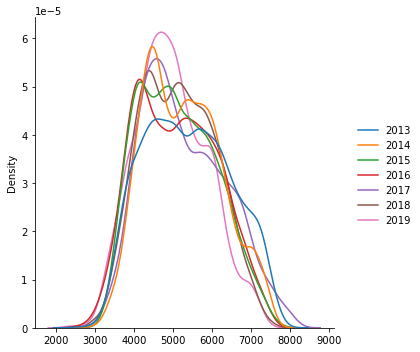

In [87]:
sns.displot(df.T,  kind="kde")

### Lag Scatter Plots
Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag=1, the observation at two time steps ago lag=2, and so on. A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot. Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis and the lag=1 observation (t-1) on the y-axis.

- If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
- If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
- Either relationship is good as they can be modeled.

More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship. A ball in the middle or a spread across the plot suggests a weak or no relationship.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

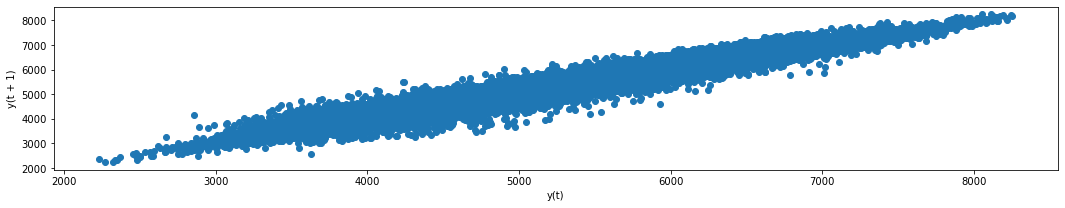

In [89]:
pd.plotting.lag_plot(s, lag=1)

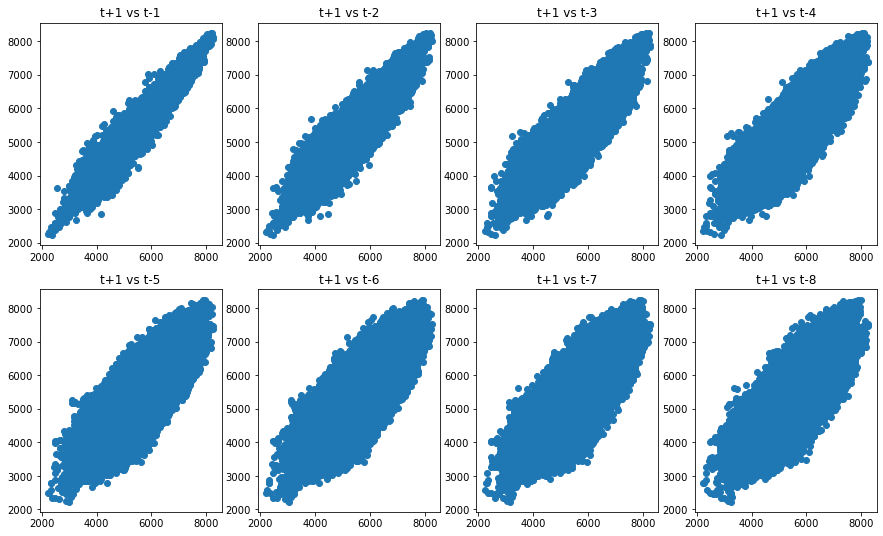

In [90]:
# create multiple scatter plots
values = pd.DataFrame(s.values)
lags = 8
columns = [values]

for i in range(1,(lags + 1)):
    columns.append(values.shift(i))

df = pd.concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
df.columns = columns

plt.figure(1, figsize=(15,9))
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)

### Autocorrelation Plots
We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation). A correlation value calculated between two groups of numbers, such as observations and their lag=1 values, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation.
Correlation values, called correlation coeficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag. This type of plot is called an autocorrelation plot.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

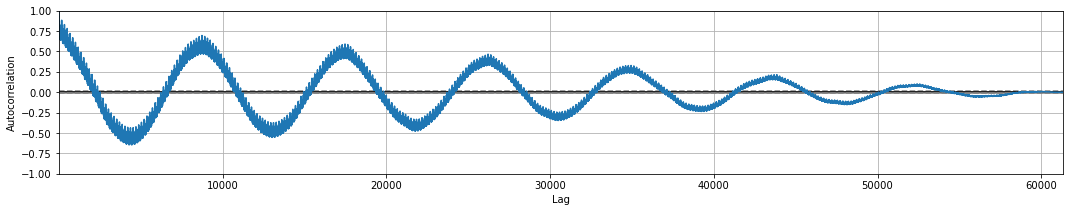

In [91]:
pd.plotting.autocorrelation_plot(s)

The Statsmodels library also provides a version of the autocorrelation plot as a line plot. Plots lags on the horizontal and the correlations on vertical axis.

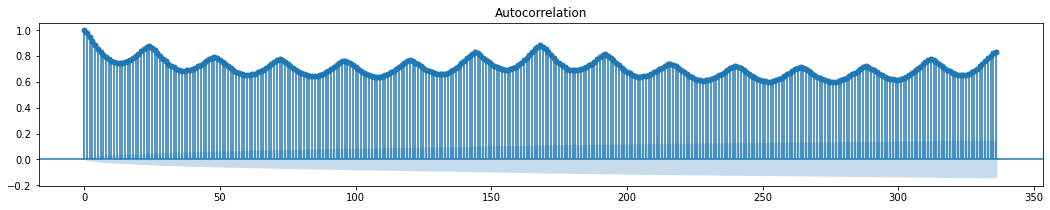

In [93]:

# autocorrelation plot of time series as a line plot
plot_acf(s, lags=336)
plt.show()

### Moving Average Smoothing
Moving average smoothing is a naive and effective technique in time series forecasting. It can be used for data preparation, feature engineering, and even directly for making predictions. Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

In [94]:
# tail-rolling average transform
rolling = s.rolling(window=3)
rolling_mean = rolling.mean()

<AxesSubplot:xlabel='timestamp'>

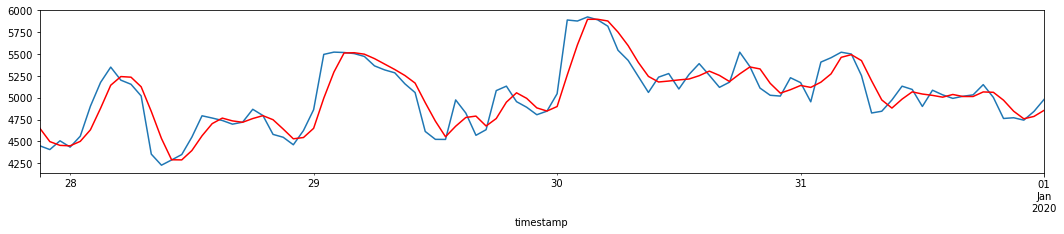

In [96]:
# plot original and transformed dataset
s[-100:].plot()
rolling_mean[-100:].plot(color='red')

### Moving Average as Prediction
The moving average value can also be used directly to make predictions. It is a naive model and assumes that the trend and seasonality components of the time series have already been removed or adjusted for. The moving average model for predictions can easily be used in a walk-forward manner. As new observations are made available (e.g. daily), the model can be updated and a prediction made for the next day.

In [101]:
# prepare problem
X = s.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
rmse = np.sqrt(mean_squared_error(test, predictions))

In [102]:
print('RMSE: %.3f' % rmse)


RMSE: 289.738


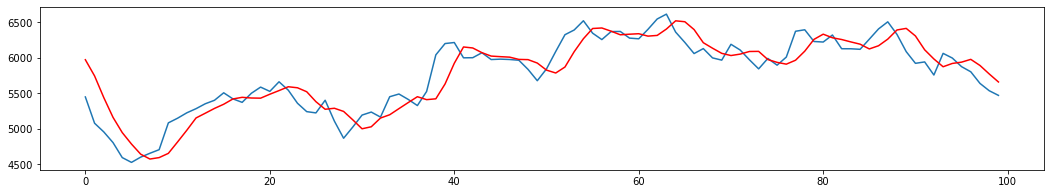

In [103]:

# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()

## Time Series Components
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.
- **Systematic:** Components of the time series that have consistency or recurrence and can be described and modeled.
- **Non-Systematic:** Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. These components are defined as follows:

- **Level:** The average value in the series.
- **Trend:** The increasing or decreasing value in the series.
- **Seasonality:** The repeating short-term cycle in the series.
- **Noise:** The random variation in the series.

Our time series dataset may contain a trend. A trend is a continued increase or decrease in the series over time. There can be benefit in identifying, modeling, and even removing trend information from your time series dataset.

Time series datasets can contain a seasonal component. This is a cycle that repeats over time, such as monthly or yearly. This repeating cycle may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models. There are many types of seasonality: time of day, daily, weekly, monthly, yearly etc. Identifying whether there is a seasonality component in your time series problem is subjective. The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at different scales and with the addition of trend lines.
A time series where the seasonal component has been removed is called seasonal stationary. If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be trend stationary.

### Stationarity in Time Series Data
The observations in a stationary time series are not dependent on time. Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations. When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.

#### Check for Stationarity
There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

- **Look at Plots:** You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
- **Summary Statistics:** You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.

Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.

<AxesSubplot:xlabel='timestamp'>

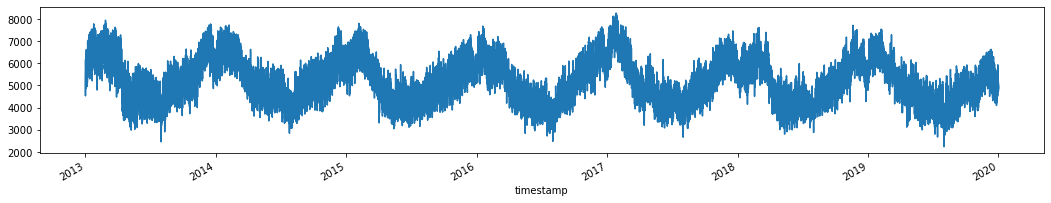

In [104]:
s.plot()

## Evaluate Models
The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross-validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.
In time series forecasting, this evaluation of models on historical data is called backtesting. We will look at three different methods that you can use to backtest your machine learning models on time series problems:
- **Train-Test split** that respects temporal order of observations.
- **Multiple Train-Test splits** that respect temporal order of observations.
- **Walk-Forward Validation** where a model may be updated each time step new data is received.

In [107]:

# calculate a train-test split of a time series dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [108]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 61344
Training Observations: 40487
Testing Observations: 20857


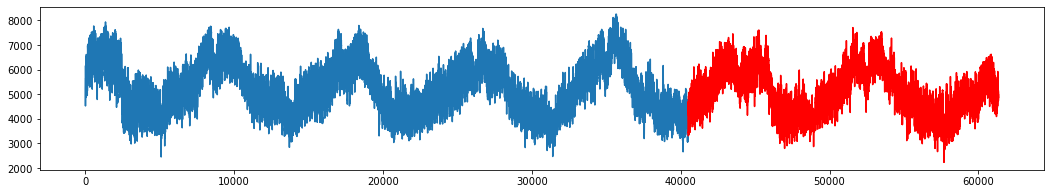

In [109]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r')

### Multiple Train-Test Splits
We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data. We could do this manually by repeating the train-split tests with different split points.

The scikit-learn library provides a time series "cross-validator" in the TimeSeriesSplit module. It provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

Observations: 30672
Training Observations: 15336
Testing Observations: 15336
-----
Observations: 46008
Training Observations: 30672
Testing Observations: 15336
-----
Observations: 61344
Training Observations: 46008
Testing Observations: 15336
-----


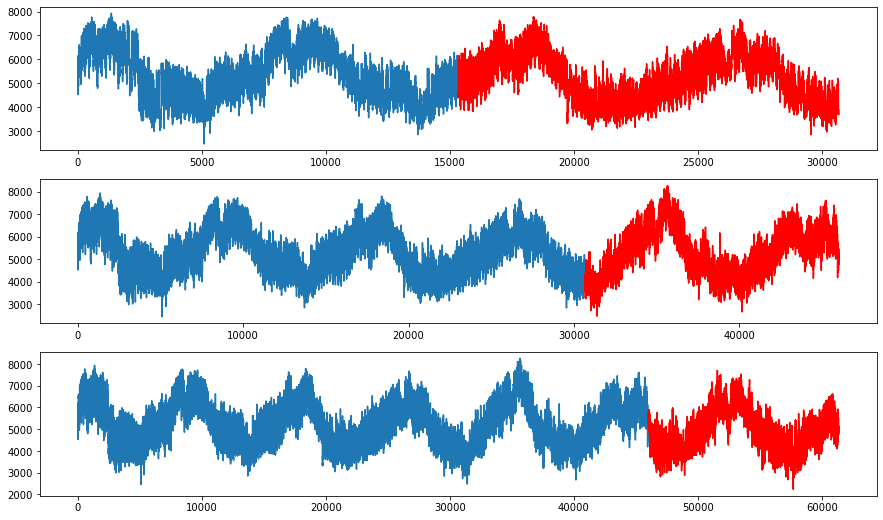

In [110]:
# calculate repeated train-test splits of time series data
X = s.values
splits = TimeSeriesSplit(n_splits=3)
index = 1
plt.figure(1, figsize=(15,9))

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))

    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test], color='r')
    index += 1
plt.show() 

Using multiple train-test splits will result in more models being trained, and in turn, a more accurate estimate of the performance of the models on unseen data. A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set. This may not be realistic as models can be retrained as new daily or monthly observations are made available.

### Walk Forward Validation
In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time step.
There are few decisions to make:
- **Minimum Number of Observations.** First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
- **Sliding or Expanding Window.** Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.

In [112]:
# walk forward validation: the train set expanding each time step and the test set fixed at one time step ahead
X = s[-100:].values
n_train = 80
n_records = len(X)

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

train=80, test=1
train=81, test=1
train=82, test=1
train=83, test=1
train=84, test=1
train=85, test=1
train=86, test=1
train=87, test=1
train=88, test=1
train=89, test=1
train=90, test=1
train=91, test=1
train=92, test=1
train=93, test=1
train=94, test=1
train=95, test=1
train=96, test=1
train=97, test=1
train=98, test=1
train=99, test=1


### Persistence Model for Forecasting
Establishing a baseline is essential on any time series forecasting problem. A baseline in performance gives you an idea of how well all other models will actually perform on your problem. Here we will develop a persistence forecast that we can use later as a baseline level of performance on this time series dataset.

The following steps are required:

- Transform the univariate dataset into a supervised learning problem.
- Establish the train and test datasets for the test harness.
- Define the persistence model.
- Make a forecast and establish a baseline performance.
- Review the complete example and plot the output.

In [113]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [114]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [116]:
# persistence model
def model_persistence(x):
    return x

In [117]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [118]:
print('Test RMSE: %.3f' % rmse)


Test RMSE: 222.401


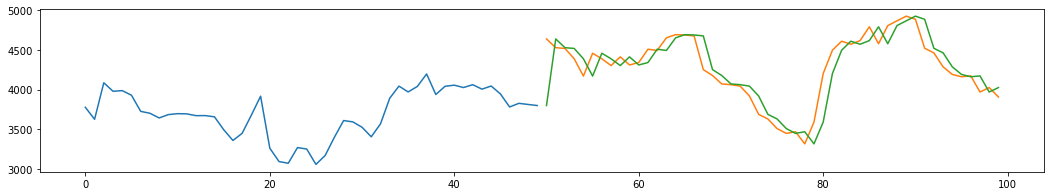

In [120]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y[:50]])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions[:50]])

### Visualize Residual Forecast Errors
Forecast errors on a time series forecasting problem are called residual errors or residuals. A residual error is calculated as the expected outcome minus the forecast. Careful exploration of residual errors on your time series prediction problem can tell you a lot about your forecast model and even suggest improvements.

In [121]:
#calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

The first plot is to look at the residual forecast errors over time as a line plot. We would expect the plot to be random around the value of 0 and not show any trend or cyclic structure.

<AxesSubplot:>

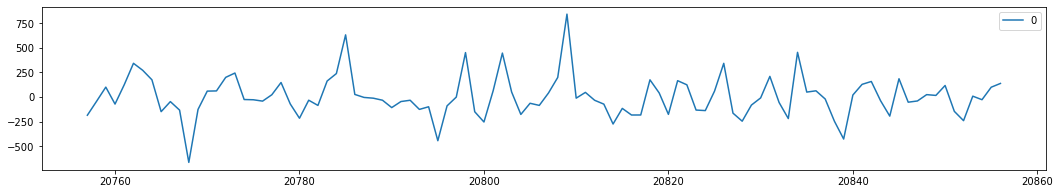

In [123]:
# plot residuals
residuals[-100:].plot()

We can calculate summary statistics on the residual errors. Primarily, we are interested in the mean value of the residual errors. A value close to zero suggests no bias in the forecasts, whereas positive and negative values suggest a positive or negative bias in the forecasts made. It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior to their use or evaluation.

In [124]:
residuals.describe()


,0
count,20857.00
mean,0.06
std,222.41
min,-1315.55
25%,-124.62
50%,-10.62
75%,113.28
max,1313.64


Plots can be used to better understand the distribution of errors beyond summary statistics. We would expect the forecast errors to be normally distributed around a zero mean.

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

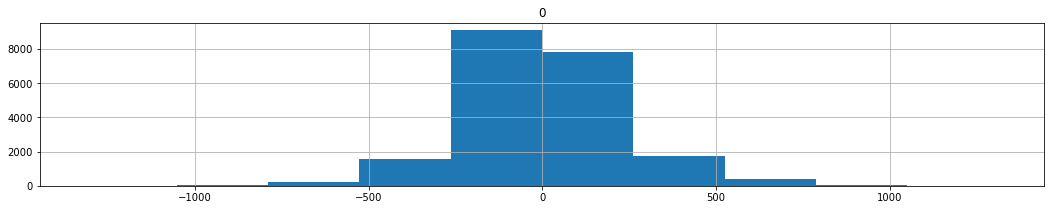

In [125]:
# histograms plot
residuals.hist()

<AxesSubplot:ylabel='Density'>

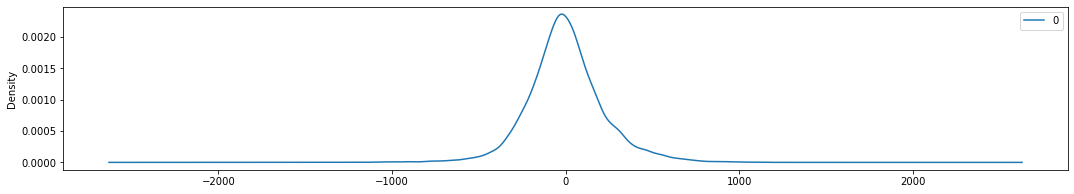

In [126]:
# density plot
residuals.plot(kind='kde')

### Residual Q-Q Plot
A Q-Q plot, or quantile plot, compares two distributions and can be used to see how similar or different they happen to be. The Q-Q plot can be used to quickly check the normality of the distribution of residual errors. The values are ordered and compared to an idealized Gaussian distribution. The comparison is shown as a scatter plot (theoretical on the x-axis and observed on the y-axis) where a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.

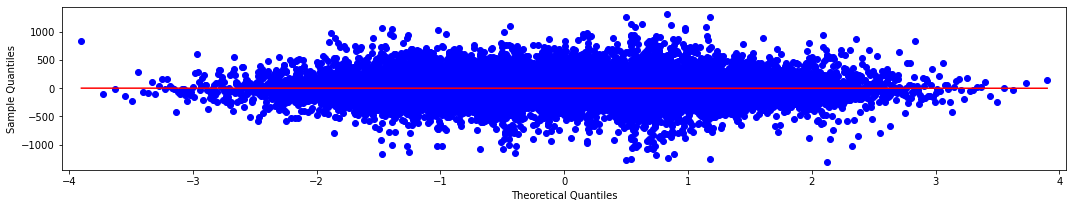

In [127]:

qqplot(residuals, line='r')
plt.show()

### Residual Autocorrelation Plot
We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being below the threshold of significance (dashed and dotted horizontal lines on the plot). A significant autocorrelation in the residual plot suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called autoregression.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

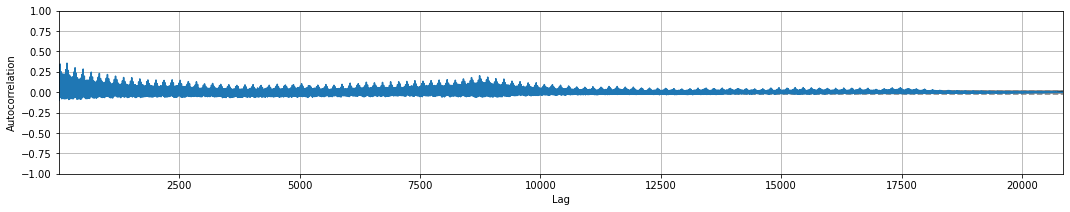

In [128]:
pd.plotting.autocorrelation_plot(residuals)


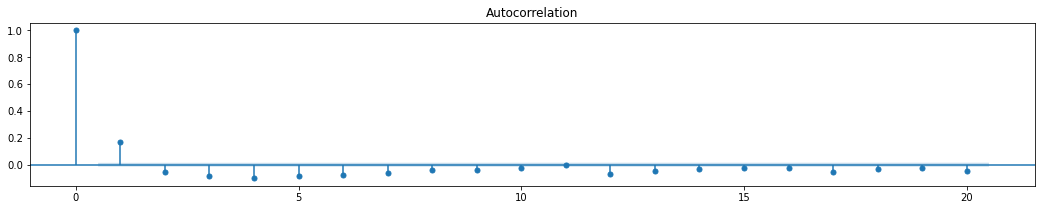

In [129]:

# autocorrelation plot of residuals as a line plot
plot_acf(residuals, lags=20)
plt.show()

### Reframe Time Series Forecasting Problems
There are many ways to reframe the forecast problem that can both simplify the prediction problem and potentially expose more or different information to be modeled. A reframing can ultimately result in better and/or more robust forecasts.

#### Classification Framings
Classification involves predicting categorical or label outputs (such as high, medium, and low). For example, we can forecast whether a change in minimum value will be small or large, or whether the new value will be lower or higher than the current value.

In [136]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [137]:
def make_discrete(row):
    if row['t+1'] < row['t']*0.97:
        return 'low'
    elif row['t+1'] > row['t']*1.03:
        return 'high'
    else:
        return 'medium'

In [138]:
# apply the above function to reassign t+1 values
df['t+1'] = df.apply(lambda row: make_discrete(row), axis=1)

In [140]:
df.sample(n=10)

,t,t+1
13121,4844.43,medium
52090,6683.20,low
27767,5843.97,low
47841,4120.84,high
20099,4707.83,medium
42038,5333.69,medium
51248,6351.70,medium
25176,4692.07,medium
45350,6051.48,medium
15533,4612.48,high


### Time Horizon Framings
- Forecast the minimum value for the next 3 months.
- Forecast the maximum value relative to the average from the past 12 months.
- Forecast the month in the next year that will have the lowest value.
- ...

In [160]:
df = make_sliding_window(1,3)
df.head()

,t0,t1,t2,t3
timestamp,,,,
2013-01-01 01:00:00,6133.65,5995.05,5790.13,5448.47
2013-01-01 02:00:00,5995.05,5790.13,5448.47,5077.96
2013-01-01 03:00:00,5790.13,5448.47,5077.96,4955.34
2013-01-01 04:00:00,5448.47,5077.96,4955.34,4805.10
2013-01-01 05:00:00,5077.96,4955.34,4805.10,4593.82


We can now define the problem as: given the minimum power from the hour before, forecast the minimum value for the next 3 days.

### Forecasting
We chose Persistence Model as our forecast performance baseline, and obtained the root mean squared error of RMSE=0.187. We would now like to improve this result.

### Autoregression Model
Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems.

In [161]:
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

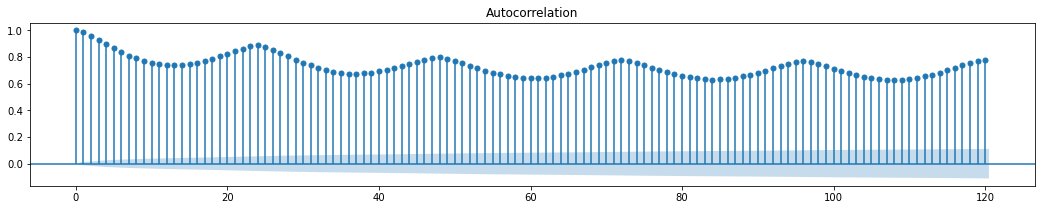

In [163]:
plot_acf(train, lags=120)
plt.show()

An autoregression model is a linear regression model that uses lagged variables as input variables. The Statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class.

In [192]:
# train autoregression
model = AutoReg(train, lags=72, old_names=False)
model_fit = model.fit()

#### Use the Model to Make Predictions for One Week


In [193]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [194]:
test_period = 24*7
rmse = np.sqrt(mean_squared_error(test[:test_period], predictions[:test_period]))

In [195]:
print('Test RMSE: %.3f' % rmse)


Test RMSE: 414.996


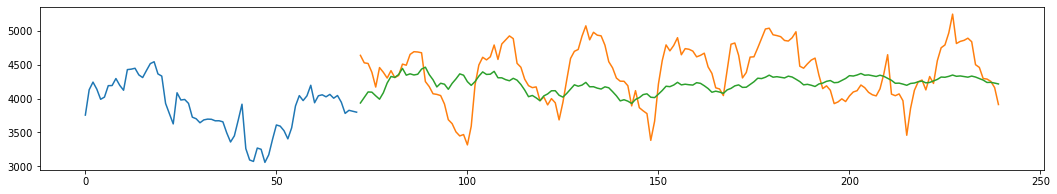

In [196]:
# plot predictions and expected results on the test data
plt.plot(train_y[-72:])
plt.plot([None for i in train_y[-72:]] + [x for x in test_y[:test_period]])
plt.plot([None for i in train_y[-72:]] + [x for x in predictions[:test_period]])

Obviously, we want to rebuild the model after each day as the new data becomes available.



## ARIMA Model for Forecasting
The Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis. An ARIMA model is a class of statistical model for analyzing and forecasting time series data.

ARIMA is an acronym that stands for Autoregressive Integrated Moving Average Model. This acronym is descriptive, capturing the key aspects of the model itself:

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:
- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **q**: The size of the moving average window, also called the order of moving average.

Let's start off with something simple. We will fit an ARIMA model to our dataset and review the residual errors. First, we fit an ARIMA(24,1,3) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

In [209]:

# fit model
model = ARIMA(s, order=(5,1,0))
model_fit = model.fit()

/home/ubuntu/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/ubuntu/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/ubuntu/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [210]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                61344
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -411217.658
Date:                Fri, 12 Feb 2021   AIC                         822447.317
Time:                        13:54:40   BIC                         822501.462
Sample:                             0   HQIC                        822464.118
                              - 61344                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2545      0.003     75.822      0.000       0.248       0.261
ar.L2         -0.0399      0.004     -9.905      0.000      -0.048      -0.032
ar.L3          0.0120      0.005      2.653      0.0

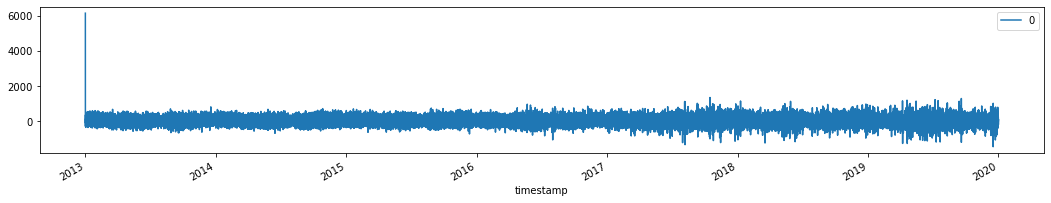

In [211]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

[(-1000.0, 1000.0)]

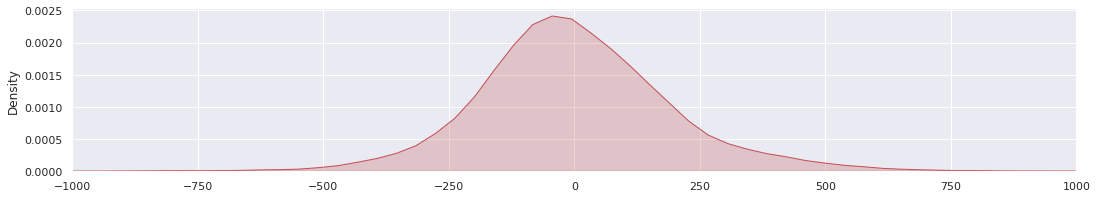

In [215]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-1000, 1000))

In [216]:

# summary stats of residuals
residuals.describe()

,0
count,61344.00
mean,0.08
std,198.83
min,-1451.52
25%,-118.76
50%,-11.38
75%,109.76
max,6133.65


#### Rolling Forecast ARIMA Model
We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

In [217]:

# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received. We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

In [ ]:
# walk-forward validation
for t in tqdm.tqdm(range(100)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

  5%|▌         | 5/100 [00:09<03:04,  1.94s/it]

We can calculate a final root mean squared error score (RMSE) for the predictions, providing a point of comparison for other ARIMA configurations.

In [ ]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)